# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
import matplotlib as mlib

def intersection(a,b):
    a = list(set(a))
    b = list(set(b))
    res = []
    for i in a:
        for j in b:
            if i == j:
                res.append(i)
    return res


A = combined.columns.values
B = survey_fields
C = intersection(A, B)

for i in C:
    print(i + ' ' + str(correlations[i]))



N_t 0.291463027518
saf_tot_11 0.318753450217
N_p 0.421530025358
com_t_11 0.0824194189013
rr_t -0.0233862911735
eng_p_11 0.0202541072223
com_tot_11 0.0773102012897
saf_s_11 0.337638744361
rr_s 0.232199129275
rr_p 0.047924518832
com_s_11 0.187370201848
eng_t_11 0.0369064785838
saf_p_11 0.122912836272
aca_t_11 0.132347667783
aca_p_11 0.0351546180087
eng_s_11 0.213821608135
aca_tot_11 0.190965977941
N_s 0.423462947509
com_p_11 -0.115073482428
eng_tot_11 0.100101829625
saf_t_11 0.313810333352
aca_s_11 0.339435473542


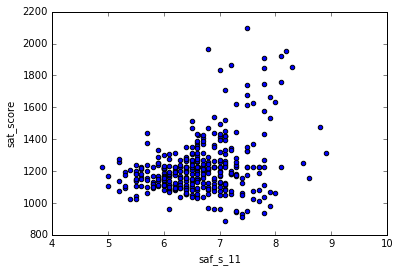

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

a = list(combined['saf_s_11'])
b = list(combined['sat_score'])

plt.scatter(a, b)
plt.xlabel('saf_s_11')
plt.ylabel('sat_score')
plt.show()

In [13]:
# sat_score and saf_s_11 show a high positive correlation, 
# as expected

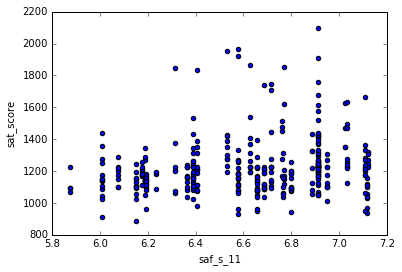

In [14]:
x = combined.groupby('school_dist')['saf_s_11'].transform('mean')
y = combined['sat_score']

plt.scatter(x, y)
plt.xlabel('saf_s_11')
plt.ylabel('sat_score')
plt.show()



In [15]:
print (combined.columns.values)

['DBN' 'SCHOOL NAME' 'Num of SAT Test Takers'
 'SAT Critical Reading Avg. Score' 'SAT Math Avg. Score'
 'SAT Writing Avg. Score' 'sat_score' 'SchoolName' 'AP Test Takers '
 'Total Exams Taken' 'Number of Exams with scores 3 4 or 5' 'Demographic'
 'School Name' 'Cohort' 'Total Cohort' 'Total Grads - n'
 'Total Grads - % of cohort' 'Total Regents - n'
 'Total Regents - % of cohort' 'Total Regents - % of grads'
 'Advanced Regents - n' 'Advanced Regents - % of cohort'
 'Advanced Regents - % of grads' 'Regents w/o Advanced - n'
 'Regents w/o Advanced - % of cohort' 'Regents w/o Advanced - % of grads'
 'Local - n' 'Local - % of cohort' 'Local - % of grads'
 'Still Enrolled - n' 'Still Enrolled - % of cohort' 'Dropped Out - n'
 'Dropped Out - % of cohort' 'CSD' 'NUMBER OF STUDENTS / SEATS FILLED'
 'NUMBER OF SECTIONS' 'AVERAGE CLASS SIZE' 'SIZE OF SMALLEST CLASS'
 'SIZE OF LARGEST CLASS' 'SCHOOLWIDE PUPIL-TEACHER RATIO' 'Name'
 'schoolyear' 'fl_percent' 'frl_percent' 'total_enrollment' 'prek'

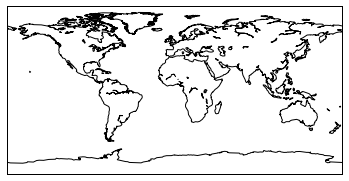

In [16]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
m = Basemap()
m.drawcoastlines()
plt.show()

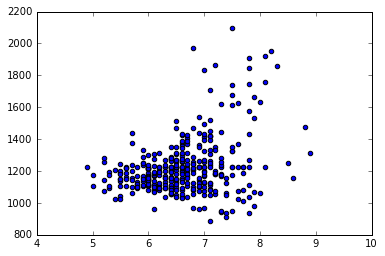

In [17]:
import matplotlib.pyplot as plt
plt.scatter(combined['saf_s_11'], combined['sat_score'])
plt.show()

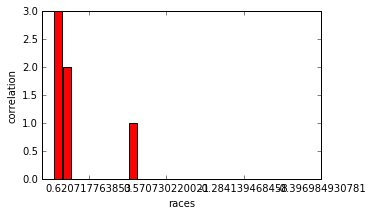

In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig, ax= plt.subplots()
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
heigth = range(len(races))
fig.set_size_inches(5, 3, forward=True)
ax.bar(correlations[races], heigth, width=0.1, align='center', 
        color='red')
ax.set_ylabel('correlation') 
ax.set_xlabel('races')
ax.set_xticks([i for i, item in enumerate(races)])
ax.set_xticklabels(correlations[races])
plt.show()

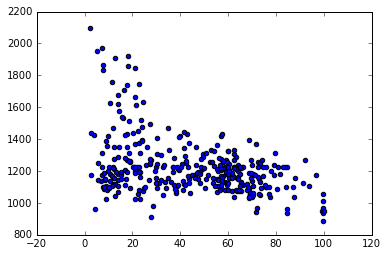

In [19]:
plt.scatter(combined['hispanic_per'], combined['sat_score'])

In [20]:
hispanic_schools = []
for i in range(len(combined)):
    if combined['hispanic_per'][i] > 95:
        hispanic_schools.append(i)
for i in hispanic_schools:
    print('school: ' + combined['SCHOOL NAME'][i])
    print('white: ' + str(combined['white_per'][i]))
    print('black: ' + str(combined['black_per'][i]))
    print('asian: ' + str(combined['asian_per'][i]))
    print('hispanic: ' + str(combined['hispanic_per'][i]))
    print('district: ' + str(combined['school_dist'][i]))
    print()

school: MANHATTAN BRIDGES HIGH SCHOOL
white: 0.0
black: 0.0
asian: 0.2
hispanic: 99.8
district: 02

school: WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
white: 0.3
black: 2.3
asian: 0.0
hispanic: 96.7
district: 06

school: GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND MATHEMATICS
white: 0.0
black: 0.0
asian: 0.0
hispanic: 99.8
district: 06

school: ACADEMY FOR LANGUAGE AND TECHNOLOGY
white: 0.0
black: 0.6
asian: 0.0
hispanic: 99.4
district: 09

school: INTERNATIONAL SCHOOL FOR LIBERAL ARTS
white: 0.0
black: 0.0
asian: 0.2
hispanic: 99.8
district: 10

school: PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
white: 0.0
black: 0.0
asian: 0.0
hispanic: 99.8
district: 12

school: MULTICULTURAL HIGH SCHOOL
white: 0.0
black: 0.2
asian: 0.0
hispanic: 99.8
district: 19

school: PAN AMERICAN INTERNATIONAL HIGH SCHOOL
white: 0.0
black: 0.0
asian: 0.0
hispanic: 100.0
district: 24



In [21]:
not_hispanic_schools = []
for i in range(len(combined)):
    if (combined['hispanic_per'][i]<10) and (combined['sat_score'][i] 
    > 1800):
        not_hispanic_schools.append(i)
for i in not_hispanic_schools:
    print('school: ' + combined['SCHOOL NAME'][i])
    print('white: ' + str(combined['white_per'][i]))
    print('black: ' + str(combined['black_per'][i]))
    print('asian: ' + str(combined['asian_per'][i]))
    print('hispanic: ' + str(combined['hispanic_per'][i]))
    print('district: ' + str(combined['school_dist'][i]))
    print('sat score: ' + str(combined['sat_score'][i]))
    print()

school: STUYVESANT HIGH SCHOOL
white: 23.7
black: 1.2
asian: 72.1
hispanic: 2.4
district: 02
sat score: 2096.0

school: BRONX HIGH SCHOOL OF SCIENCE
white: 25.4
black: 3.5
asian: 63.5
hispanic: 7.2
district: 10
sat score: 1969.0

school: BROOKLYN TECHNICAL HIGH SCHOOL
white: 21.3
black: 10.2
asian: 60.3
hispanic: 7.9
district: 13
sat score: 1833.0

school: QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK COLLEGE
white: 6.7
black: 10.5
asian: 74.4
hispanic: 7.9
district: 28
sat score: 1868.0

school: STATEN ISLAND TECHNICAL HIGH SCHOOL
white: 61.3
black: 1.1
asian: 31.8
hispanic: 5.3
district: 31
sat score: 1953.0



In [22]:
# except the STATEN ISLAND TECHNICAL HIGH SCHOOL, that has a majority
# of white kids, everyone else has a majority of asian kids
# removing the filter on the presence of hispanic kids, the best
# hispanic presence in a top school is in the 
# HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGINEERING AT CITY 
# COLLEGE, with 21.2 percent
# in the 9 top schools, we have 6 with asian majority, and 3 with
# white majority
# there is a dominance of those races, or the sat tests are biased?

In [23]:
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

In [24]:
import pandas
male_sat_corr = combined['sat_score'].corr(combined['male_per'])
female_sat_corr = combined['sat_score'].corr(combined['female_per'])
print('male presence and sat score: ' + str(male_sat_corr))
print('female presence and sat score: ' + str(female_sat_corr))
print()
top_schools = []
for i in range(len(combined)):
    if int(combined['sat_score'][i]) > 1800:
        top_schools.append(i)
print(len(top_schools))
for i in top_schools:
    print('school: ' + combined['SCHOOL NAME'][i])
    print('male: ' + str(combined['male_per'][i]))
    print('female: ' + str(combined['female_per'][i]))
    print('white: ' + str(combined['white_per'][i]))
    print('black: ' + str(combined['black_per'][i]))
    print('asian: ' + str(combined['asian_per'][i]))
    print('hispanic: ' + str(combined['hispanic_per'][i]))
    print('sat score: ' + str(combined['sat_score'][i]))
    print()


male presence and sat score: -0.11206243686
female presence and sat score: 0.112107739422

9
school: BARD HIGH SCHOOL EARLY COLLEGE
male: 31.3
female: 68.7
white: 49.8
black: 15.1
asian: 15.1
hispanic: 18.2
sat score: 1856.0

school: STUYVESANT HIGH SCHOOL
male: 59.3
female: 40.7
white: 23.7
black: 1.2
asian: 72.1
hispanic: 2.4
sat score: 2096.0

school: HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGINEERING AT CITY COLLEGE
male: 65.8
female: 34.2
white: 26.1
black: 15.0
asian: 36.2
hispanic: 21.2
sat score: 1847.0

school: BRONX HIGH SCHOOL OF SCIENCE
male: 57.8
female: 42.2
white: 25.4
black: 3.5
asian: 63.5
hispanic: 7.2
sat score: 1969.0

school: HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
male: 53.8
female: 46.2
white: 53.8
black: 10.6
asian: 16.7
hispanic: 18.0
sat score: 1920.0

school: BROOKLYN TECHNICAL HIGH SCHOOL
male: 58.3
female: 41.7
white: 21.3
black: 10.2
asian: 60.3
hispanic: 7.9
sat score: 1833.0

school: TOWNSEND HARRIS HIGH SCHOOL
male: 28.9
female: 71.1
white: 

In [25]:
# girls have better results on average, with a slight positive 
# correlation. The top schools though have better results from boys

In [26]:
good_schools_f = []
for i in range(len(combined)):
    if int(combined['sat_score'][i]) > 1700:
        if combined['female_per'][i] > 60:
            good_schools_f.append(i)
for i in good_schools_f:
    print('school: ' + combined['SCHOOL NAME'][i])
    print('male: ' + str(combined['male_per'][i]))
    print('female: ' + str(combined['female_per'][i]))
    print('white: ' + str(combined['white_per'][i]))
    print('black: ' + str(combined['black_per'][i]))
    print('asian: ' + str(combined['asian_per'][i]))
    print('hispanic: ' + str(combined['hispanic_per'][i]))
    print('sat score: ' + str(combined['sat_score'][i]))
    print()



school: BARD HIGH SCHOOL EARLY COLLEGE
male: 31.3
female: 68.7
white: 49.8
black: 15.1
asian: 15.1
hispanic: 18.2
sat score: 1856.0

school: ELEANOR ROOSEVELT HIGH SCHOOL
male: 32.5
female: 67.5
white: 63.7
black: 5.5
asian: 17.2
hispanic: 11.6
sat score: 1758.0

school: BEACON HIGH SCHOOL
male: 39.0
female: 61.0
white: 49.8
black: 14.6
asian: 8.9
hispanic: 22.8
sat score: 1744.0

school: FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & ART AND PERFORMING ARTS
male: 26.4
female: 73.6
white: 49.2
black: 12.9
asian: 19.6
hispanic: 16.6
sat score: 1707.0

school: TOWNSEND HARRIS HIGH SCHOOL
male: 28.9
female: 71.1
white: 24.6
black: 5.9
asian: 55.5
hispanic: 12.9
sat score: 1910.0



In [27]:
# we have 5 good schools with a predominance of girls of at least 
# 60%, while there is just one with a mele predominance. what is more 
# interesting is that, out of five schools, four have are mostly 
# 'white' schools

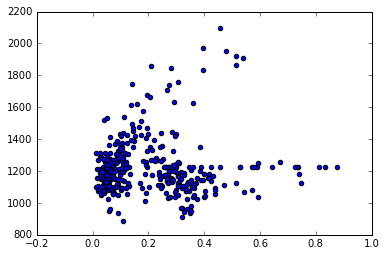

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
ap_per = []
for i in range(len(combined)):
    ap_per.append(combined['AP Test Takers '][i] / combined['total_enrollment'][i])
plt.scatter(ap_per, combined['sat_score'])
plt.show()

In [37]:
crr = combined['AVERAGE CLASS SIZE'].corr(combined['sat_score'])
print(crr)
# there is a correlation of 0.38 between class size and sat_score
# it means that schools with larger classes have a better sat score
# weird!!!

0.38101433081


In [43]:
lst = combined.groupby('school_dist')['sat_score'].mean()
print(x)
# district 22 has an average sat score of 1450
# district 12 has an average sat score of a little more than 11

school_dist
01    1354.500000
02    1295.638184
03    1293.443035
04    1224.142857
05    1285.062687
06    1164.643881
07    1128.846154
08    1159.665129
09    1131.971940
10    1222.227273
11    1165.000000
12    1101.823134
13    1237.187600
14    1179.459915
15    1190.604312
16    1120.109701
17    1161.428571
18    1118.000000
19    1103.833333
20    1273.687761
21    1206.312619
22    1450.500000
23    1157.333333
24    1242.000000
25    1357.000000
26    1377.600000
27    1224.300000
28    1347.846947
29    1181.929851
30    1326.382090
31    1382.500000
32    1119.500000
Name: sat_score, dtype: float64
